# Introduction
The linear advection equation is a canonical partial differential equation that represents the non-dissipative transport of a conserved quantity, $u$. Advection is found in a wide range of possibly nonlinear physical processes, such as mass, momentum, and energy transport in fluid mechanics. Advection is a part of the nonlinear Navier-Stokes equations, for example. As such, it is important that any quantum algorithm that solves classical partial differential equations is able to simulate advection. A recent paper by Jin and Liu, Quantum Sci. Technol., 2024, (https://arxiv.org/pdf/2308.00646) find that analog quantum simulation of a D-dimensional linear advection equation requires at most D qumodes through a process knowned as Schrödingerisation. 



Specifically, the 1D linear advection equation is written as: 

$\frac{\partial u}{\partial t} + b \frac{\partial u}{\partial x}= 0$, 

where $u(x,t)$ is a scalar conserved quantity such as fluid concentration, and $b\in\mathbb{R}$ is a constant advection velocity. If $b>0$ then any initial condition $u(x, t=0)$ is translated towards the positive $x$ direction at a rate given by $b$. Indeed, the analytical solution for the 1D linear advection equation is: 

$u(x,t) = u_0(x-b t)$, 

where $u_0=u_0(x)$ represents the initial condition (any function on $\mathbb{R}$). For example, if $u$ represents the scalar concentration of red dye in a fluid, then the action of the linear advection equation with $b>0$ is to transport the initial blob of dye to the right with zero dissipation or other change to the total amount of dye. 

# Schrödingerization
It is shown in the paper by Jin and Liu that one may map the linear advection equation onto a D-qumode quantum system. To begin, one may write a qumode expanded in the infinite-dimensional eigenbasis of the position operator, $\hat{x}$,

$|u(x,t)\rangle = \frac{1}{||u||} \int_{-\infty}^{\infty}{u(x,t) |x\rangle \mathrm{d}x}$, 

that has been normalised by the $l_2$ norm, $||u||$. An important observation is that the momentum operator may be written as 

$\hat{p}=-i\frac{\partial}{\partial x}$. 

With this key observation, it becomes possible to rewrite the linear advection operator to be: 

$\frac{d|u\rangle}{dt} = -iH|u\rangle$, 

where the Hamiltonian $H = b \hat{p}$. Given that the Hamiltonian is time-dependent and the advection velocity $b$ is a constant, it follows that the solution at time $t$ is given by

$|u(t)\rangle = e^{-iHt} |u(0)\rangle = e^{-ib\hat{p}t}|u(0)\rangle$

Therefore, Hamiltonian simulation of a single qumode using unitary displacement operators, $U=\exp(-ib\hat{p}t)$ is a method to solve the linear advection equation using analog quantum computing. We shall demonstrate the linear advection equation can be solved using OQD's SDK. 

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import eval_hermite, factorial
import seaborn as sns
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.interface.analog.operator import Annihilation, Creation
from oqd_analog_emulator.qutip_backend import QutipBackend 
from oqd_core.interface.analog.operator import PauliI, PauliX, PauliY, PauliZ

from oqd_core.backend.metric import Expectation
from oqd_core.backend.task import Task, TaskArgsAnalog

### Creating the momentum and position operators
The momentum operator $\hat{p}$ can be written in terms of the bosonic annihilation and creation operators, $\hat{a}, \hat{a}^\dagger$, respectively, in the Fock basis as: 

$\hat{p}= -\frac{i}{\sqrt{2}} (\hat{a}-\hat{a}^\dagger)$

Similarly, the position operator $\hat{x}$ is

$\hat{x} = \frac{1}{\sqrt{2}} (\hat{a} + \hat{a}^\dagger)$

For completeness, the annihilation and creation operators may be written in terms of the momentum and position operators as: 

$\hat{a}=\frac{1}{\sqrt{2}}(\hat{x}+i\hat{p}), ~~~~~~~~\hat{a}^\dagger = \frac{1}{\sqrt{2}}(\hat{x}-i\hat{p})$.


In [2]:

## Define the momentum and position operators
a = Annihilation()
c = Creation()

# Momentum operator is p = sqrt(hbar)/(sqrt(2)i) (creation - annihilation)
prefactor = -1j/np.sqrt(2)
p = prefactor*(a-c) 

# Position operator is x = sqrt(hbar/2) (annihilation + creation)
prefac = 1/np.sqrt(2)
x = prefac*(c+a)

### Helper functions
1. Reconstruction of a wavefunction from a sum of Fock states. For concreteness, we assume the Fock bases are from a quantum harmonic oscillator. $\psi_n(x)=\langle x|n\rangle = \frac{1}{\sqrt{2^n n!}}\Big(\frac{1}{\pi}\Big)^{\frac{1}{4}} \exp(-\frac{x^2}{2}) H_n(x)$, where $H_n(x)$ is the physicist's Hermite polynomial and $|n\rangle$ is the $\text{n}^{\text{th}}$ Fock state. 
2. Processing a list of Fock state coefficients
3. Generate the analytical solution given that the initial condition is the vacuum state $|0\rangle$. 
4. Show initial condition

In [3]:

## This sums up Fock states
# Assuming we have a quantum harmonic oscillator's Fock states. 
# 1D version
def wavefunction(xgrid, weights, hbar=1):
    # The nth Fock state is \psi_n(x) = <x_n | n> = 1/sqrt(2^n n!) * (pi hbar)^{-1/4} * exp(-x^2/2hbar) H_n(x/\sqrt(hbar))

    total_num = len(weights)

    output = np.zeros(shape=xgrid.shape, dtype=complex)
    for n in range(total_num):
        output+= weights[n]*((1/np.sqrt(2**n * factorial(n))) * ((np.pi * hbar)**(-0.25)) * np.exp(-(xgrid**2)/(2*hbar)) * eval_hermite(n, xgrid))
    return output

# Parse the weights
def make_weight_list(state):
    weights = np.zeros(shape = len(state) ,dtype = complex)
    for n in range(len(state)):
        weights[n] = state[n].real + state[n].imag*1j

    return weights

# u(x,t) = u0(x-a*t)
def analytical_solution(xgrid, a,t):
    # Assuming that the initial condition is the vacuum state,
    return wavefunction(xgrid-a*t, [1])

# Show the initial condition
def show_initial_condition(xgrid):
    return wavefunction(xgrid, [1])

### Set physical and numerical parameters
#### Physical 


In [4]:
b = +1 # constant advection velocity
n = 1 # 1 qubit represents 1 spatial dimension of the linear advection equation, x

#### Numerical

In [5]:
dt = 1e-2 # timestep of the Hamiltonian simulation
tfinal = 3 # final time of the simulation
num_fock_states = 100 
xgrid = np.linspace(-4,4,10000) # This is the grid of 10,000 grid points in the x direction

### Set up the circuit and run parameters

In [6]:
## Define the circuit and its protocols
hamiltonian = AnalogGate(hamiltonian = b*p) # A displacement operator
# The initial condition is the vacuum state |0>
# |0>= 1/(pi hbar)^1/4 \int dx exp(-x^2/2hbar) |x>
circuit = AnalogCircuit()
circuit.evolve(duration = tfinal, gate = hamiltonian) # Hamiltonian simulation i.e., apply exp(-i H t) to total time of 1
circuit.measure()

# Define 
args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=num_fock_states, # 100 Fock states in total
    metrics={
        "x": Expectation(operator = x)
    },
    dt=dt,
)
task = Task(program = circuit, args = args)


### Let's visualise the initial condition $u(x, t=0)$

c:\ProgramData\anaconda3\envs\oqd1\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\envs\oqd1\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


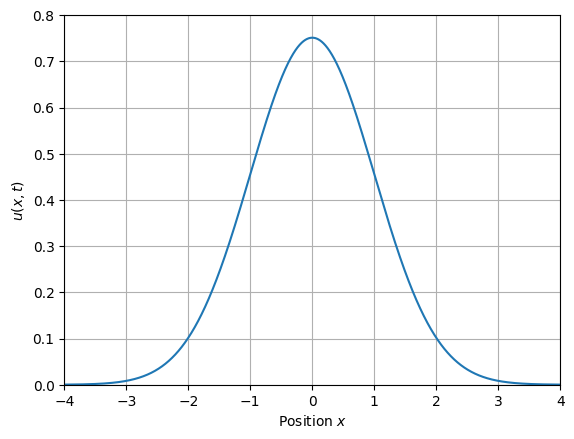

In [9]:
ic = show_initial_condition(xgrid)
plt.plot(xgrid, ic, label="Initial condition $u(x,t=0)")
plt.xlabel(f"Position $x$")
plt.ylabel(f"$u(x,t)$")
plt.xlim([-4,4])
plt.ylim([0, 0.8])
plt.grid()

### Run the Hamiltonian simulation 

In [10]:
backend = QutipBackend()
results = backend.run(task = task)

### Plot the simulated solution $u(x,t)$

Notice how it resembles the initial condition translated to the right by 3 length units given that 3 time units have passed. This is because the advection speed is $b = 3/3 = 1$. 

c:\ProgramData\anaconda3\envs\oqd1\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\envs\oqd1\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


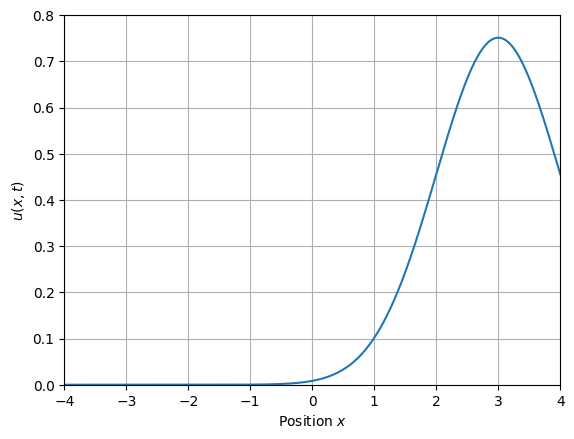

In [12]:
## Plot the wavefunction
weights = make_weight_list(results.state)
xgrid = np.linspace(-4,4,10000)

u = wavefunction(xgrid, weights)

plt.plot(xgrid, u, label="u(x, t=3)")
plt.xlabel(f"Position $x$")
plt.ylabel(f"$u(x,t)$")
plt.xlim([-4,4])
plt.ylim([0, 0.8])
plt.grid()

### Now visualise the evolution of the solution from $t=0$ to $t=3$

It should be clear that the action of the advection is to translate the initial condition $u(x, t=0)$ to the positive $x$-direction at a rate of $b$. Note that the integrated norm of the wavefunctions at any given time is 1 or numerically close to 1 per the trapezoidal rule. 

In [13]:
t_samples = [1,2,3] # sample the solution at time 1, 2, 3. 

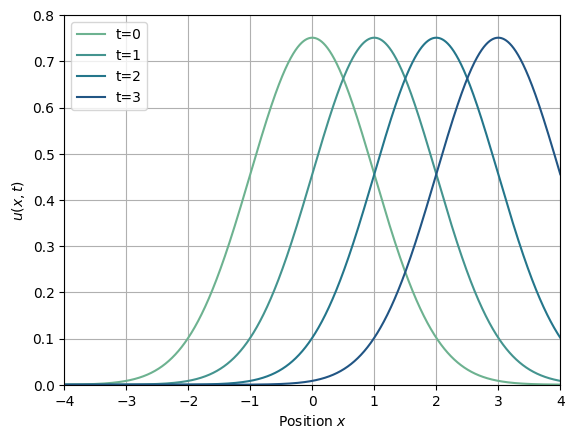

In [14]:
# for t = 0
# The initial condition is the vacuum state |0>
# |0>= 1/(pi hbar)^1/4 \int dx exp(-x^2/2hbar) |x>
circuit = AnalogCircuit()
circuit.evolve(duration = dt, gate = hamiltonian) # Hamiltonian simulation i.e., apply exp(-i H t) to total time of 1
circuit.measure()

args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=num_fock_states, # 100 Fock states in total
    metrics={
        "x": Expectation(operator = x)
    },
    dt=dt,
)
task = Task(program = circuit, args = args)

## Run the Hamiltonian simulation
backend = QutipBackend()
results = backend.run(task = task)

## Plot the wavefunction
weights = make_weight_list(results.state)
xgrid = np.linspace(-4,4,10000)

u = wavefunction(xgrid, weights)
colours = sns.color_palette(palette="crest", n_colors=len(t_samples)+1)

plt.plot(xgrid, u, label="t="+str(0), color = colours[0])#, linestyle='--')
plt.xlabel(f"Position $x$")
plt.ylabel(f"$u(x,t)$")
plt.grid()

# For loop of Hamiltonian simulations at time t = 1, 2, 3
counter = 1
for t in t_samples:
    circuit = AnalogCircuit()
    circuit.evolve(duration = t, gate = hamiltonian) # Hamiltonian simulation i.e., apply exp(-i H t) to total time of 1
    circuit.measure()

    task = Task(program = circuit, args = args)

    ## Run the Hamiltonian simulation
    results = backend.run(task = task)

    ## Plot the wavefunction
    weights = make_weight_list(results.state)
    u = wavefunction(xgrid, weights)
    
    plt.plot(xgrid, u, label="t="+str(t), color = colours[counter])
    plt.xlabel(f"Position $x$")
    plt.ylabel(f"$u(x,t)$")
    plt.grid()
    counter+=1

plt.legend()
plt.xlim([-4, 4])
plt.ylim([0, 0.8])
plt.grid()
plt.show()

### Compare against the analytical solution

We know that the analytical solution of the linear advection equation is $u(x,t) = u_0(x-b*t)$. Let us compare the results of the Hamiltonian simulation (presented as the circular markers) against the analytical solutiion (presented as the solid black lines at the various time steps). The results of the Hamiltonian simulation are in good quantitative agreement with the analyical solution; the $l_2$-norm error is $3\times10^{-5}$ while the $l_\infty$-norm error is $8\times10^{-7}$. 

c:\ProgramData\anaconda3\envs\oqd1\Lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


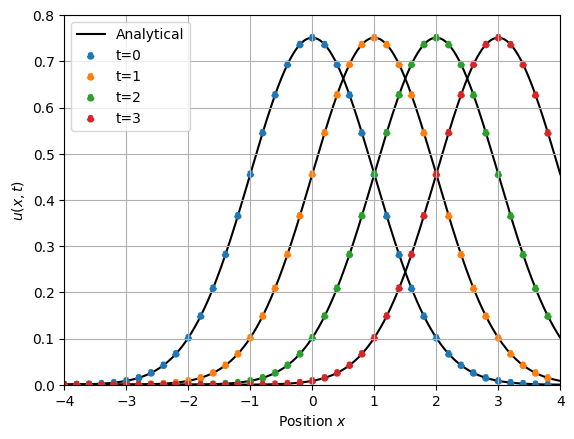

In [15]:

# for t = 0
# The initial condition is the vacuum state |0>
# |0>= 1/(pi hbar)^1/4 \int dx exp(-x^2/2hbar) |x>
circuit = AnalogCircuit()
circuit.evolve(duration = dt, gate = hamiltonian) # Hamiltonian simulation i.e., apply exp(-i H t) to total time of 1
circuit.measure()

args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=num_fock_states, # 100 Fock states in total
    metrics={
        "x": Expectation(operator = x)
    },
    dt=dt,
)
task = Task(program = circuit, args = args)

## Run the Hamiltonian simulation
backend = QutipBackend()
results = backend.run(task = task)

## Plot the initial wavefunction
weights = make_weight_list(results.state)
xgrid = np.linspace(-4,4,10000)

u = wavefunction(xgrid, weights)
colours = sns.color_palette(palette="crest", n_colors=len(t_samples)+1)


u_analytical = analytical_solution(xgrid, b, 0)
plt.plot(xgrid, u_analytical, label="Analytical", color = 'k', zorder=0)

nskip = 250
plt.scatter(xgrid[::nskip], u[::nskip], label="t="+str(0), linestyle='--',s=20)
plt.xlabel(f"Position $x$")
plt.ylabel(f"$u(x,t)$")
plt.grid()

# For loop of Hamiltonian simulations at time t = 1, 2, 3
counter = 1
for t in t_samples:
    circuit = AnalogCircuit()
    circuit.evolve(duration = t, gate = hamiltonian) # Hamiltonian simulation i.e., apply exp(-i H t) to total time of 1
    circuit.measure()
    task = Task(program = circuit, args = args)

    ## Run the Hamiltonian simulation
    results = backend.run(task = task)

    ## Plot the initial and final wavefunction
    weights = make_weight_list(results.state)

    # wavefunction
    u = wavefunction(xgrid, weights)

    u_analytical = analytical_solution(xgrid, b, t)
    plt.plot(xgrid, u_analytical, label="_nolegend_", color = 'k', zorder=0)

    plt.scatter(xgrid[::nskip], u[::nskip], label="t="+str(t), linestyle='--',s=20)
    plt.xlabel(f"Position $x$")
    plt.ylabel(f"$u(x,t)$")
    plt.grid()
    counter+=1
    plt.legend()
plt.xlim([-4, 4])
plt.ylim([0, 0.8])
plt.grid()
plt.show()

### Conclusions 

We were able to demonstrate that the linear advection equation could be solved using analog quantum computing to good accuracy. We note that efficient state preparation and measurement are open questions currently being addressed, so this demonstration did not tackle those issues in detail. Furthermore, Schrödingerisation is not only applicable to the linear advection equation; it is valid for a wide range of partial differential equations that may be nonlinear or dissipative such as the heat equation, Fokker-Planck equation, Black-Scholes equation, and Hamilton-Jacobi equations. 